In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [3]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

#### Data Processing

In [4]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

In [5]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_list = [t for ts in (hypo_tokens+prem_tokens) for t in ts]
    word_counter = {}
    for word in token_list:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    sorted_words = sorted(word_counter, key = word_counter.get, reverse = True)
    id2token = ['<unk>','<pad>'] + sorted_words[:(max_vocab_size)]
    token2id = {tok: ind for ind, tok in enumerate(id2token)}
    return token2id,id2token

**Coding 2: finish `token2index` function** (2 pts)

In [6]:
def token2index(tokens_data, token2id):
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    indices_data = []
    for sentence in tokens_data:
        sentence_ind = []
        for word in sentence:
            if word in token2id:
                sentence_ind.append(token2id.get(word))
            else:
                sentence_ind.append(UNK_IDX)
        indices_data.append(sentence_ind)
    return indices_data

In [66]:
# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.05

# training parameters
num_epochs = 10 
batch_size = 1024

In [8]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=max_vocab_size)
hypo_data_indices_train = token2index(hypo_data_tokens_train,token2id)
prem_data_indices_train = token2index(prem_data_tokens_train,token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val,token2id)
prem_data_indices_val= token2index(prem_data_tokens_val,token2id) 

#### DataLoader

In [9]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [10]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [11]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [12]:
# TODO:
# finish DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=newsgroup_collate_func)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=newsgroup_collate_func)

---
#### Model

In [13]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.n_out = n_out
        self.reduce = reduce
        self.embed = nn.Embedding(vocab_size, emb_dim,padding_idx=PAD_IDX)
        if reduce == 'concat':
            self.lin = nn.Linear(2*emb_dim,n_out)
        else:
            self.lin = nn.Linear(emb_dim,n_out)
        
    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param : an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        
        hyp_emb = self.embed(data_hypo)
        hyp_emb = torch.div(torch.sum(hyp_emb,dim=1),length_hypo.reshape(-1,1))
        
        prem_emb = self.embed(data_prem)
        prem_emb = torch.div(torch.sum(prem_emb,dim=1),length_prem.reshape(-1,1))
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat
        if self.reduce == 'concat':
            out = torch.concat((hyp_emb,prem_emb),dim=1)
        if self.reduce == 'sum':
            out = torch.add(hyp_emb,prem_emb)
        if self.reduce == 'hadamard':
            out = hyp_emb*prem_emb
        
        # hidden layers 
        out = self.lin(out)    #(batch_size,n_out)
        
        return out

---
#### Training and Validation

In [67]:
model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = [] # records training loss after every epoch
val_losses = [] # records validation loss after every epoch
train_accs = [] # records training accuracy after every epoch
val_accs = [] # records validation accuracy after every epoch

train_losses_batch = [] # records training loss after every batch
val_losses_batch = [] # records validation loss after every batch
train_accs_batch = [] # records training accuracy after every batch
val_accs_batch = [] # records validation accuracy after every batch

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [68]:
# training:

for epoch in range(num_epochs):
    train_correct=0
    val_correct=0
    train_total=0
    val_total=0
    train_loss=0
    val_loss=0
    # do train
    model.train()
#     train_log_cache = []
    for i, (hyp_inp, hyp_len, prem_inp, prem_len, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        hyp_inp = hyp_inp.to(current_device)
        prem_inp = prem_inp.to(current_device)
        label = label.to(current_device)
        
        out = model(hyp_inp, hyp_len, prem_inp, prem_len)
        out_preds = F.softmax(out,dim=1).argmax(dim=1)
        train_correct += torch.sum(out_preds==label)
        train_total += len(hyp_len)
        batch_acc = torch.sum(out_preds==label)/len(hyp_len)
        train_accs_batch.append(batch_acc)
        loss = criterion(out,label)
        train_loss+=loss.item()
        train_losses_batch.append(loss.item())
        loss.backward()
        optimizer.step()

#         train_log_cache.append(loss.item())

#         if i % 30 == 0:
#             avg_loss = sum(train_log_cache)/len(train_log_cache)
#             print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
#             train_log_cache = []
    train_losses.append(train_loss/len(train_dataloader))
    train_accs.append(train_correct/train_total)#(sum(train_accs_batch)/len(train_accs_batch))
    
    #do valid
#     valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (hyp_inp, hyp_len, prem_inp, prem_len, label) in enumerate(val_dataloader):
            hyp_inp = hyp_inp.to(current_device)
            prem_inp = prem_inp.to(current_device)
            label = label.to(current_device)
            out = model(hyp_inp, hyp_len, prem_inp, prem_len)
            out_preds = F.softmax(out,dim=1).argmax(dim=1)
            val_correct += torch.sum(out_preds==label)
            val_total += len(hyp_len)
            batch_acc = torch.sum(out_preds==label)/len(hyp_len)
            val_accs_batch.append(batch_acc)
            loss = criterion(out,label)
            val_loss+=loss.item()
            val_losses_batch.append(loss.item())
#             valid_losses.append(loss.item())
#         avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation acc after {} epoch = {:.{prec}f}'.format(epoch+1, val_correct/val_total, prec=4))
    val_losses.append(val_loss/len(val_dataloader))
    val_accs.append(val_correct/val_total)#(sum(val_accs_batch)/len(val_accs_batch))

Validation acc after 1 epoch = 0.6430
Validation acc after 2 epoch = 0.6490
Validation acc after 3 epoch = 0.6500
Validation acc after 4 epoch = 0.6320
Validation acc after 5 epoch = 0.6300
Validation acc after 6 epoch = 0.6230
Validation acc after 7 epoch = 0.6190
Validation acc after 8 epoch = 0.6000
Validation acc after 9 epoch = 0.6040
Validation acc after 10 epoch = 0.6100


In [56]:
per_epoch_metrics = {}

per_epoch_metrics['train_accs'] = train_accs
per_epoch_metrics['val_accs'] = val_accs
per_epoch_metrics['train_losses'] = train_losses
per_epoch_metrics['val_losses'] = val_losses

#### Performance variation based on hyper-parameter values

In [20]:
def plot_over_training(per_epoch_metrics, title_name):
  """
  Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t = np.arange(0, len(per_epoch_metrics['train_accs']))
  train_acc = per_epoch_metrics['train_accs']
  val_acc = per_epoch_metrics['val_accs']
  train_loss = per_epoch_metrics['train_losses']
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('acc', color=color)
  ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
  ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')
  ax2 = ax1.twinx() 

  color = 'tab:blue'
  ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
  ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='lower right')
  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

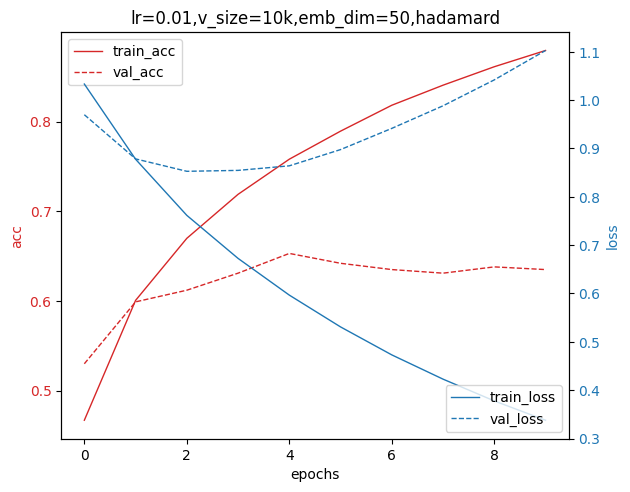

In [22]:
plot_over_training(per_epoch_metrics,"lr=0.01,v_size=10k,emb_dim=50,hadamard")

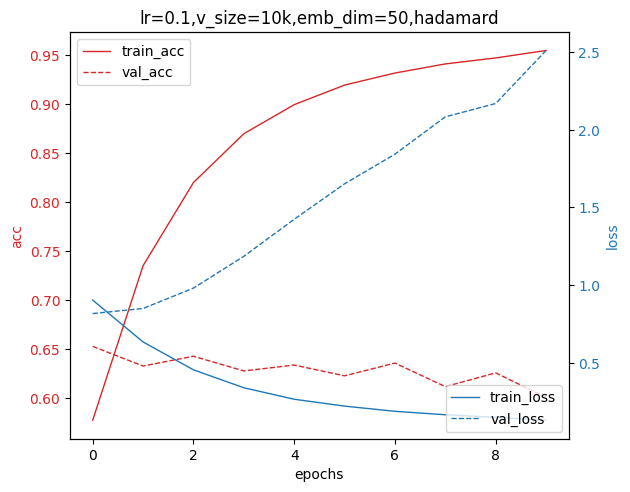

In [27]:
plot_over_training(per_epoch_metrics,"lr=0.1,v_size=10k,emb_dim=50,hadamard")

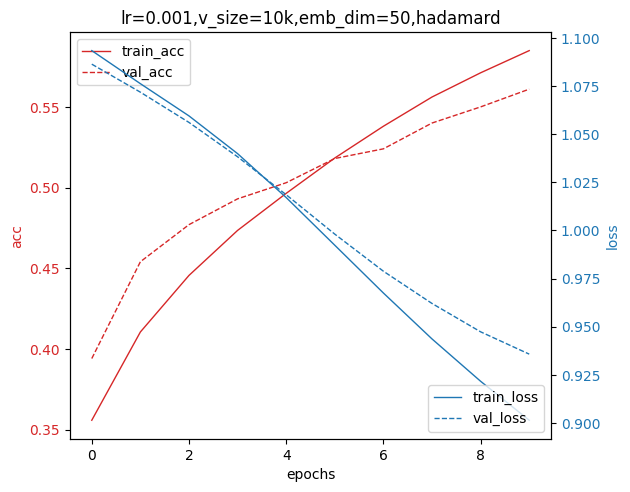

In [32]:
plot_over_training(per_epoch_metrics,"lr=0.001,v_size=10k,emb_dim=50,hadamard")

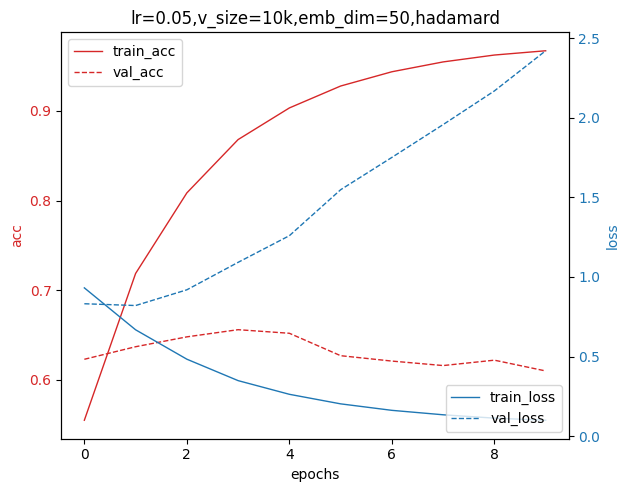

In [37]:
plot_over_training(per_epoch_metrics,"lr=0.05,v_size=10k,emb_dim=50,hadamard")

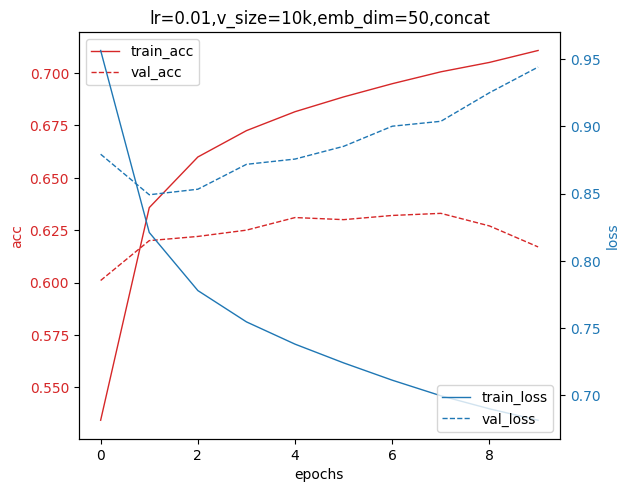

In [42]:
plot_over_training(per_epoch_metrics,"lr=0.01,v_size=10k,emb_dim=50,concat")

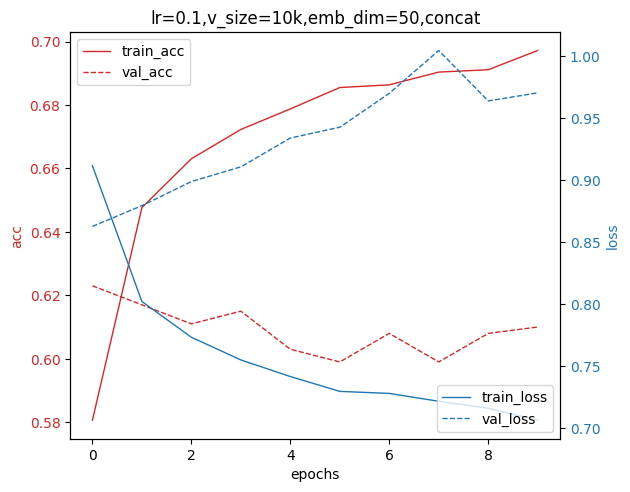

In [47]:
plot_over_training(per_epoch_metrics,"lr=0.1,v_size=10k,emb_dim=50,concat")

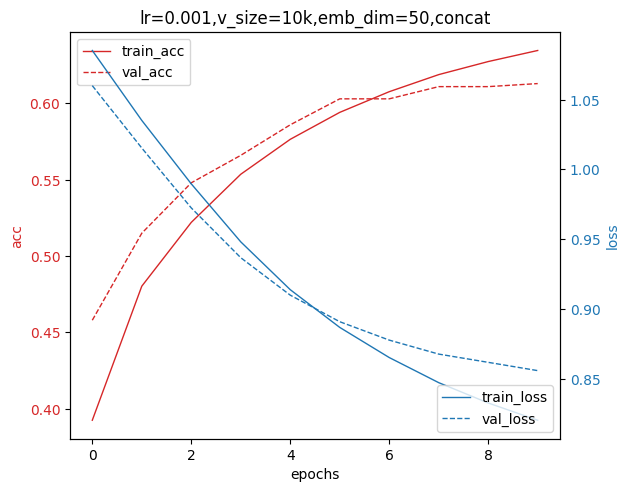

In [52]:
plot_over_training(per_epoch_metrics,"lr=0.001,v_size=10k,emb_dim=50,concat")

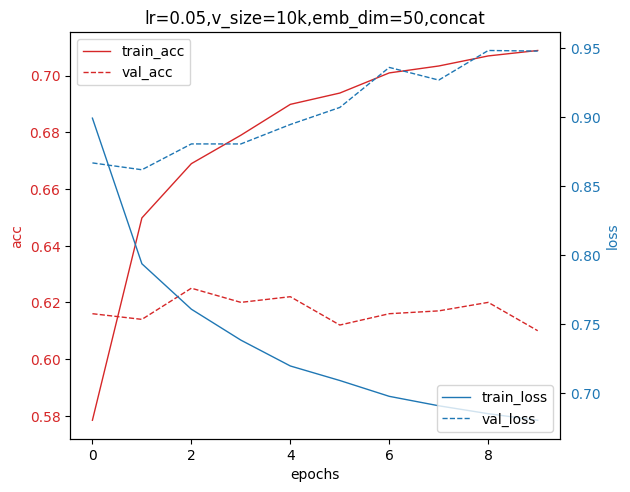

In [57]:
plot_over_training(per_epoch_metrics,"lr=0.05,v_size=10k,emb_dim=50,concat")

In [86]:
hypo_batch,hypo_l,prem_batch,prem_l,label_batch = next(iter(val_dataloader))

In [97]:
ind = 5
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['a', 'woman', 'wearing', 'a', 'brown', 'jacket', 'and', 'brown', 'pants', 'is', 'walking', 'her', 'two', 'dogs', 'along', 'the', 'beach', 'as', 'they', 'follow']
hypotheses:  ['a', 'person', 'walks', 'two', 'animals', 'along', 'the', 'beach']
label:  1
predicted label:  1


In [104]:
ind = 546
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['a', 'child', 'in', 'winter', 'gear', 'is', 'hiding', 'inside', 'a', 'cave', 'made', 'of', 'snow', 'while', 'it', 'is', 'snowing']
hypotheses:  ['a', 'child', 'in', 'winter', 'gear', 'is', 'hiding', 'from', 'his', 'friends', 'in', 'a', 'cave', 'made', 'of', 'snow']
label:  0
predicted label:  0


In [99]:
ind = 932
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['people', 'walk', 'amongst', 'a', 'traffic', 'jam', 'in', 'a', 'crowded', 'city']
hypotheses:  ['the', 'traffic', 'is', '<unk>', 'and', 'people', 'are', 'walking', 'between', 'the', 'cars']
label:  1
predicted label:  1


In [98]:
ind = 43
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['a', 'woman', 'seated', 'indoors', 'wearing', 'glasses', 'an', 'orange', 'shirt', 'jeans', 'and', 'sandals', 'is', 'eating', 'from', 'a', 'container', 'in', 'her', 'hand']
hypotheses:  ['a', 'woman', 'waits', 'for', 'her', 'husband', 'to', 'come', 'home', 'for', 'dinner']
label:  0
predicted label:  2


In [101]:
ind = 999
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['an', 'older', 'woman', 'on', 'the', 'computer']
hypotheses:  ['woman', 'learning', 'to', 'use', 'her', 'personal', 'computer']
label:  0
predicted label:  1


In [102]:
ind = 22
print("premise: ", [id2token[x] for x in prem_batch[ind] if x!=PAD_IDX])
print("hypotheses: ", [id2token[x] for x in hypo_batch[ind] if x!=PAD_IDX])
print("label: ", label_batch[ind].item())
model.eval()
preds = F.softmax(model(hypo_batch,hypo_l,prem_batch,prem_l),dim=1).argmax(dim=1)
print("predicted label: ", preds[ind].item())

premise:  ['a', 'woman', 'is', 'sitting', 'in', 'a', 'man', "'s", 'lap', 'in', 'a', 'brown', 'armchair']
hypotheses:  ['the', 'woman', 'and', 'man', 'are', 'resting', 'together', 'in', 'an', 'armchair']
label:  1
predicted label:  2
